In [1]:
!pip install pypdf2

     |████████████████████████████████| 81kB 4.8MB/s 
  Created wheel for pypdf2: filename=PyPDF2-1.26.0-cp37-none-any.whl size=61102 sha256=2df645f19d4883c69b8e2604be787c1f4f5f60dd9c760c32e596be732911c46e
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built pypdf2


In [2]:
import PyPDF2

In [3]:
import csv
import datetime
import numpy
import scipy
import scipy.sparse
import numpy as np

In [4]:
def _build_patient_mapping(patients):
  """
 Create a mapping of the patient identifier to an index
 """
  pmap = {}
  for ii in range(len(patients)):
    pmap[patients[ii]] = ii
  return patmap
def _build_feature_mapping(features):
  """
 Create a mapping of the feature name to an index
 """
  fmap = {}
  for ii in range(len(features)):
    fmap[features[ii]] = ii
  return fmap
t0 = datetime.datetime.strptime('01/01/1900', "%m/%d/%Y")

def _map_time_to_dayId(time):
  """
 Convert datetime into an integer day offset from some base date (01-01-1900)
 to facilitate date difference computations.
 """
  t = datetime.datetime.strptime(time, "%m/%d/%Y")
  d = t - t0
  return d.days

In [5]:
def loadPatientCohortDataFile(fileName):
  """
 Read in a patient cohort data file with columns: patientId, label, operational
Date (yyyy-mm-dd format)
 label is 0 for controls and 1 for cases
 operationalDate for cases is the diagnosis date
 operationalDate for controls is the diagnosis date for the matching control
 627,0,2001-07-28
 628,0,2001-07-28
 629,1,2004-11-14
 639,1,2004-02-19
 Generate 3 mappings
 pidMap: patientId -> integer (offset)
 labelMap: patientId -> label
 dateIdMap: patientId -> operationalDateId
 """
# Load raw data
  pdf = open(fileName, 'rb')
  pdfReader = PyPDF2.PdfFileReader(pdf)
  num_pages=pdfReader.numPages
  n=0
  pidMap = {}
  labelMap = {}
  dateIdMap = {}

  for i in range(num_pages):
    page=pdfReader.getPage(i)
    lines=page.extractText().split("\n")
    j=0
    while j < (len(lines))-1:
      pidMap[int(lines[j])]=n
      labelMap[int(lines[j])]=int(lines[j+1])
      dateIdMap[int(lines[j])]=int(_map_time_to_dayId(lines[j+2]))
      n+=1
      j+=3
    




# Return results
  return pidMap, labelMap, dateIdMap

In [6]:
def loadPatientDataFile(fileName):
  """
 Read input data with columns: patientId, date (yyyy-mm-dd format), featureName
, featureValue
 627,1998-11-08,DIAGNOSIS:401.9,1.0
 627,1999-05-21,DIAGNOSIS:401.9,1.0
 628,1998-09-30,DIAGNOSIS:401.9,1.0
 628,1998-11-01,DIAGNOSIS:401.9,1.0
 627,1999-08-07,ACE_Inhibitors:ACE_Inhibitors,1.0
 627,1999-12-04,Angiotensin_II_Receptor_Antagonists,1.0
 627,1999-12-04,Loop_Diuretics,1.0
 627,2000-06-11,Beta_Blockers_Cardio-Selective,1.0
 628,1998-09-30,Antiadrenergic_Antihypertensives,1.0
 628,1998-11-01,Antiadrenergic_Antihypertensives,1.0
 627,2000-06-11,Vital:BloodPressure:DIAS_BP,70.0
 627,2000-06-11,Vital:BloodPressure:SYS_BP,142.0
 628,1998-09-30,Vital:BloodPressure:DIAS_BP,78.0
 628,1998-09-30,Vital:BloodPressure:SYS_BP,142.0
 Convert it into a numeric matrix format with columns: patientId, dateId, featu
reId, featureValue
  """
  pdfFileObj = open(fileName, 'rb')
  data=[]
  features=[]
  pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
  for i in range(pdfReader.numPages):
    lines=pdfReader.getPage(i).extractText()
    lines=lines.split("\n")
    j=0
    while j<len(lines)-1:
      d=[int(lines[j]),int(_map_time_to_dayId(lines[j+1])),lines[j+2],int(lines[j+3])]
      data.append(d)
      features.append(lines[j+2])
      j+=4
    feature_map=_build_feature_mapping(list(set(features)))
  for i in range(len(data)):
    data[i][2]=int(feature_map[data[i][2]])
  return np.asarray(data),feature_map

In [7]:
from collections import defaultdict
def get_rnn_input(A,pw,ow,pidMap,featureMap,opDateMap):
  """ Computes a one hot representation of features for pateints encounters depending upon prediction window,
  observation window to feed into the rnn model
  A: patientId dateId featureId featureValue
  pw: prediction window
  ow: observation window
  pidMap: dictionary mapping of patientId -> row offset
  featureMap : dictionary mapping of featureName -> column offset
  opDateMap: dictionary mapping of patientId -> operationalDateId
  """
  max_no_features=max(featureMap.values())
  x=[0]*(max_no_features+1)
  encounters=defaultdict(list)
  count=0
  for ii in range(A.shape[0]):
    if A[ii, 0] in pidMap:
      pid = pidMap[int(A[ii, 0])]
      fid = int(A[ii, 2])
      opd = opDateMap[int(A[ii, 0])]
      x=[0]*(max_no_features+1)
      val = A[ii, 3]
      if (A[ii, 1] > (opd - ow - pw)) and (A[ii, 1] < (opd - pw)):
        if pid >= 0:
          if val > 0:
            x[fid]=1
            count+=1
            encounters[pid].append(fid+1)
    

  
  
  return encounters



In [26]:
data,featureMap=loadPatientDataFile("/content/daignosis_record.pdf")

In [27]:
pidMap, labelMap, opDateMap = loadPatientCohortDataFile("/content/patient_cohort.pdf")

In [28]:
en=get_rnn_input(data,365,730,pidMap,featureMap,opDateMap)

In [29]:
#Creating input
X=[]
for x in en:
  X.append(en[x])

In [31]:
Y=[]
inv=list(labelMap.keys())
for i in en:
  Y.append(labelMap[inv[i]])

In [32]:
#creatig test and train set
#X=np.asarray(X)
from sklearn.utils import shuffle
X,Y=shuffle(X,Y)
fr=int(len(X)*0.7)
X_train,X_test=X[:fr],X[fr:]
Y_train,Y_test=Y[:fr],Y[fr:]

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    X_train, padding="post"
)

In [34]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [35]:
padded_inputs=np.expand_dims(padded_inputs,axis=-1)

In [36]:
from keras.layers import Lambda
# We will use `one_hot` as implemented by one of the backends
from keras import backend as K

def OneHot(input_dim=None, input_length=None):
    # Check if inputs were supplied correctly
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    # Helper method (not inlined for clarity)
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    # Final layer representation as a Lambda layer
    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

In [37]:

model = Sequential()
VOCAB_SIZE=max(featureMap.values())
MAX_SEQUENCE_LENGTH=19
model.add(OneHot(input_dim=VOCAB_SIZE+1,
                 input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(64))

model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC(),"acc"])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 19, 6)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                18176     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
history = model.fit(padded_inputs, np.array(Y_train), epochs=1000, verbose=1)

Epoch 1/1000
8/8 [==============================] - 3s 11ms/step - loss: 0.6622 - auc_2: 0.5537 - acc: 0.6601
Epoch 2/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.4796 - auc_2: 0.5946 - acc: 0.8862
Epoch 3/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.3655 - auc_2: 0.5322 - acc: 0.8847
Epoch 4/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.3731 - auc_2: 0.5148 - acc: 0.8785
Epoch 5/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.3784 - auc_2: 0.5207 - acc: 0.8682
Epoch 6/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.3869 - auc_2: 0.5279 - acc: 0.8641
Epoch 7/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.4050 - auc_2: 0.5292 - acc: 0.8605
Epoch 8/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.4147 - auc_2: 0.5326 - acc: 0.8523
Epoch 9/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.3582 - auc_2: 0.5395 - acc: 0.8804
Epoch 10/1

In [39]:
history.history.keys()

dict_keys(['loss', 'auc_2', 'acc'])

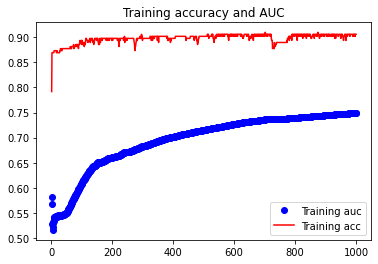

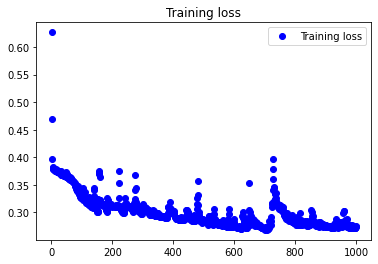

In [40]:
auc = history.history['auc_2']
acc = history.history['acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, auc, 'bo', label='Training auc')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy and AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [41]:
padded_inputs_t = tf.keras.preprocessing.sequence.pad_sequences(
    X_test, padding="post"
)
model.evaluate(padded_inputs_t,np.array(Y_test))

4/4 [==============================] - 1s 5ms/step - loss: 0.5823 - auc_2: 0.7493 - acc: 0.8774


[0.582279622554779, 0.7492691278457642, 0.8773584961891174]

Modelling for medication data

In [ ]:
data,featureMap=loadPatientDataFile("/content/medication_record.pdf")

In [ ]:
en=get_rnn_input(data,365,730,pidMap,featureMap,opDateMap)

In [ ]:
##Creating features
X=[]
for x in en:
  X.append(en[x])

In [ ]:
##creating labels
Y=[]
inv=list(labelMap.keys())
for i in en:
  Y.append(labelMap[inv[i]])

In [ ]:
from sklearn.utils import shuffle
X,Y=shuffle(X,Y)
fr=int(len(X)*0.7)
X_train,X_test=X[:fr],X[fr:]
Y_train,Y_test=Y[:fr],Y[fr:]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    X_train, padding="post"
)

In [ ]:
model = Sequential()
VOCAB_SIZE=max(featureMap.values())
MAX_SEQUENCE_LENGTH=padded_inputs.shape[1]
model.add(OneHot(input_dim=VOCAB_SIZE+1,
                 input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(51))

model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC(),"acc"])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 36, 51)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 51)                21012     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 52        
Total params: 21,064
Trainable params: 21,064
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(padded_inputs, np.array(Y_train), epochs=2000, verbose=1)

Epoch 1/2000
7/7 [==============================] - 3s 19ms/step - loss: 0.7168 - auc_4: 0.4887 - acc: 0.3236
Epoch 2/2000
7/7 [==============================] - 0s 20ms/step - loss: 0.5551 - auc_4: 0.5124 - acc: 0.8930
Epoch 3/2000
7/7 [==============================] - 0s 18ms/step - loss: 0.3897 - auc_4: 0.5233 - acc: 0.9082
Epoch 4/2000
7/7 [==============================] - 0s 19ms/step - loss: 0.3699 - auc_4: 0.4948 - acc: 0.8771
Epoch 5/2000
7/7 [==============================] - 0s 22ms/step - loss: 0.3818 - auc_4: 0.5045 - acc: 0.8748
Epoch 6/2000
7/7 [==============================] - 0s 20ms/step - loss: 0.4162 - auc_4: 0.5040 - acc: 0.8598
Epoch 7/2000
7/7 [==============================] - 0s 19ms/step - loss: 0.3138 - auc_4: 0.5154 - acc: 0.9041
Epoch 8/2000
7/7 [==============================] - 0s 19ms/step - loss: 0.3580 - auc_4: 0.5250 - acc: 0.8762
Epoch 9/2000
7/7 [==============================] - 0s 18ms/step - loss: 0.3248 - auc_4: 0.5276 - acc: 0.8932
Epoch 10/2

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f298a142830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


In [ ]:
padded_inputs_t = tf.keras.preprocessing.sequence.pad_sequences(
    X_test, padding="post")
model.evaluate(padded_inputs_t,np.array(Y_test))

3/3 [==============================] - 0s 9ms/step - loss: 1.0508 - auc_4: 0.8498 - acc: 0.8229


[1.0508004426956177, 0.8498491644859314, 0.8229166865348816]

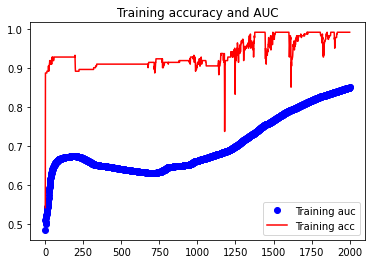

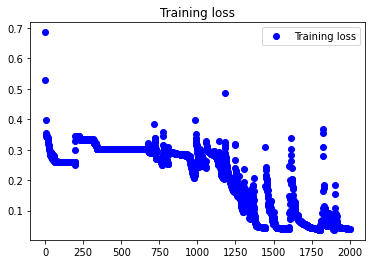

In [ ]:
auc = history.history['auc_4']
acc = history.history['acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, auc, 'bo', label='Training auc')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy and AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

modelling of vitals data


In [ ]:
from collections import defaultdict
def get_rnn_input_vitals(A,pw,ow,pidMap,featureMap,opDateMap):
  """ Computes a one hot representation of features for pateints encounters depending upon prediction window,
  observation window to feed into the rnn model
  A: patientId dateId featureId featureValue
  pw: prediction window
  ow: observation window
  pidMap: dictionary mapping of patientId -> row offset
  featureMap : dictionary mapping of featureName -> column offset
  opDateMap: dictionary mapping of patientId -> operationalDateId
  """
  max_no_features=max(featureMap.values())
  x=[0]*(max_no_features+1)
  encounters=defaultdict(list)
  count=0
  for ii in range(A.shape[0]):
    if A[ii, 0] in pidMap:
      pid = pidMap[int(A[ii, 0])]
      fid = int(A[ii, 2])
      opd = opDateMap[int(A[ii, 0])]
      x=[0]*(max_no_features+1)
      val = A[ii, 3]
      if (A[ii, 1] > (opd - ow - pw)) and (A[ii, 1] < (opd - pw)):
        if pid >= 0:
          if val > 0:
            x[fid]=val
            count+=1
            encounters[pid].append(x)
    

  
  
  return encounters


In [ ]:
data,featureMap=loadPatientDataFile("/content/vitals_record.pdf")

In [ ]:
en=en=get_rnn_input_vitals(data,365,730,pidMap,featureMap,opDateMap)

In [ ]:
X=[]
for x in en:
  X.append(en[x])

In [ ]:
Y=[]
inv=list(labelMap.keys())
for i in en:
  Y.append(labelMap[inv[i]])

In [ ]:
from sklearn.utils import shuffle
X,Y=shuffle(X,Y)
fr=int(len(X)*0.7)
X_train,X_test=X[:fr],X[fr:]
Y_train,Y_test=Y[:fr],Y[fr:]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    X_train, padding="post"
)

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [ ]:
model = Sequential()
VOCAB_SIZE=max(featureMap.values())
MAX_SEQUENCE_LENGTH=padded_inputs.shape[1]
#model.add(OneHot(input_dim=VOCAB_SIZE+1,input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.Masking(mask_value=[0,0],input_shape=(74, 2)))
model.add(LSTM(32,input_shape=(74,2)))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC(),"acc"])

model.build((None,74,2))
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 74, 2)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                4480      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(padded_inputs, np.array(Y_train), epochs=1000, verbose=1)

Epoch 1/1000
11/11 [==============================] - 6s 47ms/step - loss: 0.4426 - auc_5: 0.4660 - acc: 0.8937
Epoch 2/1000
11/11 [==============================] - 1s 46ms/step - loss: 0.3978 - auc_5: 0.4826 - acc: 0.8917
Epoch 3/1000
11/11 [==============================] - 1s 46ms/step - loss: 0.3551 - auc_5: 0.4866 - acc: 0.9008
Epoch 4/1000
11/11 [==============================] - 0s 45ms/step - loss: 0.3511 - auc_5: 0.4818 - acc: 0.8931
Epoch 5/1000
11/11 [==============================] - 1s 47ms/step - loss: 0.3819 - auc_5: 0.4742 - acc: 0.8738
Epoch 6/1000
11/11 [==============================] - 1s 46ms/step - loss: 0.3821 - auc_5: 0.4802 - acc: 0.8737
Epoch 7/1000
11/11 [==============================] - 1s 49ms/step - loss: 0.3408 - auc_5: 0.4891 - acc: 0.8945
Epoch 8/1000
11/11 [==============================] - 0s 45ms/step - loss: 0.3554 - auc_5: 0.4879 - acc: 0.8866
Epoch 9/1000
11/11 [==============================] - 1s 46ms/step - loss: 0.2840 - auc_5: 0.4955 - acc:

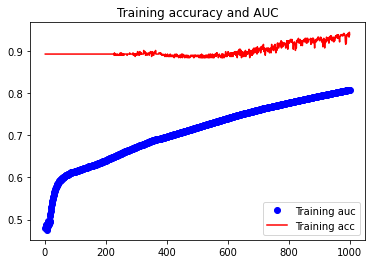

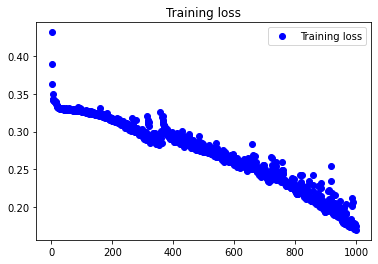

In [ ]:
auc = history.history['auc_5']
acc = history.history['acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, auc, 'bo', label='Training auc')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy and AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

combining all features

In [ ]:
data,featureMap=loadPatientDataFile("/content/combined_features.pdf")

In [ ]:
data=data.tolist()
data.sort(key=lambda x:x[1])



In [ ]:
data=np.asarray(data)

In [ ]:
data.shape

(17705, 4)

In [ ]:
from collections import defaultdict
def get_rnn_input_vitals(A,pw,ow,pidMap,featureMap,opDateMap):
  """ Computes a one hot representation of features for pateints encounters depending upon prediction window,
  observation window to feed into the rnn model
  A: patientId dateId featureId featureValue
  pw: prediction window
  ow: observation window
  pidMap: dictionary mapping of patientId -> row offset
  featureMap : dictionary mapping of featureName -> column offset
  opDateMap: dictionary mapping of patientId -> operationalDateId
  """
  max_no_features=max(featureMap.values())
  x=[0]*(max_no_features+1)
  encounters=defaultdict(list)
  count=0
  for ii in range(A.shape[0]):
    if A[ii, 0] in pidMap:
      pid = pidMap[int(A[ii, 0])]
      fid = int(A[ii, 2])
      opd = opDateMap[int(A[ii, 0])]
      x=[0]*(max_no_features+1)
      val = A[ii, 3]
      if (A[ii, 1] > (opd - ow - pw)) and (A[ii, 1] < (opd - pw)):
        if pid >= 0:
          if val > 0:
            x[fid]=val
            count+=1
            encounters[pid].append(x)
    

  
  
  return encounters


In [ ]:
en=get_rnn_input_vitals(data,365,730,pidMap,featureMap,opDateMap)

In [ ]:
X=[]
for x in en:
  X.append(en[x])

In [ ]:
Y=[]
inv=list(labelMap.keys())
for i in en:
  Y.append(labelMap[inv[i]])

In [ ]:
from sklearn.utils import shuffle
X,Y=shuffle(X,Y)
fr=int(len(X)*0.7)
X_train,X_test=X[:fr],X[fr:]
Y_train,Y_test=Y[:fr],Y[fr:]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    X_train, padding="post"
)

In [ ]:
padded_inputs.shape

(347, 130, 59)

In [ ]:
model = Sequential()
VOCAB_SIZE=max(featureMap.values())
MAX_SEQUENCE_LENGTH=padded_inputs.shape[1]
#model.add(OneHot(input_dim=VOCAB_SIZE+1,input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.Masking(mask_value=[0]*59,input_shape=(130, 59)))
model.add(LSTM(60,input_shape=(130,59)))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC(),"acc"])

model.build((None,130,59))
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_2 (ModuleWrap (None, 130, 59)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60)                28800     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 61        
Total params: 28,861
Trainable params: 28,861
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(padded_inputs, np.array(Y_train), epochs=400, verbose=1)

Epoch 1/400
11/11 [==============================] - 6s 97ms/step - loss: 0.6462 - auc_7: 0.6026 - acc: 0.6212
Epoch 2/400
11/11 [==============================] - 1s 98ms/step - loss: 0.4319 - auc_7: 0.5329 - acc: 0.9008
Epoch 3/400
11/11 [==============================] - 1s 96ms/step - loss: 0.3454 - auc_7: 0.5031 - acc: 0.9068
Epoch 4/400
11/11 [==============================] - 1s 99ms/step - loss: 0.3203 - auc_7: 0.4911 - acc: 0.9061
Epoch 5/400
11/11 [==============================] - 1s 95ms/step - loss: 0.3175 - auc_7: 0.4872 - acc: 0.9049
Epoch 6/400
11/11 [==============================] - 1s 98ms/step - loss: 0.3338 - auc_7: 0.4845 - acc: 0.8971
Epoch 7/400
11/11 [==============================] - 1s 98ms/step - loss: 0.3029 - auc_7: 0.4859 - acc: 0.9099
Epoch 8/400
11/11 [==============================] - 1s 96ms/step - loss: 0.3013 - auc_7: 0.4870 - acc: 0.9106
Epoch 9/400
11/11 [==============================] - 1s 97ms/step - loss: 0.2761 - auc_7: 0.4943 - acc: 0.9183
E

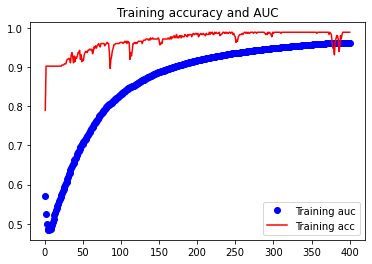

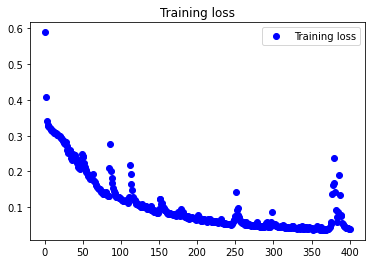

In [ ]:
auc = history.history['auc_7']
acc = history.history['acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, auc, 'bo', label='Training auc')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy and AUC')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [ ]:
padded_inputs_t = tf.keras.preprocessing.sequence.pad_sequences(
    X_test, padding="post")
model.evaluate(padded_inputs_t,np.array(Y_test))

5/5 [==============================] - 4s 18ms/step - loss: 0.9360 - auc_7: 0.9616 - acc: 0.8400


[0.9359666705131531, 0.9615706205368042, 0.8399999737739563]